<a href="https://colab.research.google.com/github/AndyMDH/pneumonia_detection_cnn/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSCK506  End of Module: Pneumonia Detection through Convolutional Neural Network (CNN)



## Table of Contents
1. [Introduction](#section-1)
2. [Exploratory Data Analysis](#section-2)
3. [Data Preprocessing and Augmentation](#section-3)
4. [CNN Architecture Development](#section-4)
5. [Model Evaluation](#section-5)
6. [Summary & Retrospective](#section-6)
7. [References](#section-7)

---
## Introduction

Pneumonia poses a severe threat to human health, being a potentially life-threatening infectious illness that typically affects one or both lungs. It is frequently triggered by bacteria, notably Streptococcus pneumoniae. According to the World Health Organization (WHO), pneumonia is responsible for one in three deaths in India (Varshni et al., 2019). Medical practitioners often rely on X-ray scans to diagnose pneumonia, distinguishing between bacterial and viral types.

This Jupyter notebook delves into the realm of automated pneumonia detection using Convolutional Neural Networks (CNNs). Specifically, it addresses the task of training a CNN model to differentiate between healthy lung scans and those afflicted with pneumonia. The dataset utilised for this endeavor is sourced from the Kaggle competition repository, offering a collection of chest X-ray images categorised as pneumonia-positive and normal.


**This task involves, but is not limited to:**

a. CNN Model Development:

- Write code to train a CNN model using the provided dataset.
- Objective: Achieve optimal performance in distinguishing between healthy and pneumonia-infected lung images.

    - **Key considerations:**
      - Define CNN architecture, including convolution-pooling blocks.
      - Fine-tune parameters like strides, padding, and activation functions for accuracy.
      - Implement strategies to prevent overfitting and ensure model generalization.

b. Training and Evaluation:

- Train the CNN model using the provided training dataset.
Fine-tune hyperparameters using validation data to enhance performance.
- Evaluate the model's accuracy using a separate test dataset to validate pneumonia detection in chest X-ray images.

This Jupyter Notebook was collaboratively prepared by:

- Minh-Dat Andy Ho Huu
- Santiago Fernandez Blanco
- Ismael Saumtally
- Chi Chuen Wan
- Chui Yi Wong

### Import Dependencies

In [4]:
!pip install keras-tuner

In [5]:
# Standard library imports
import logging
import os
import random
import warnings
from zipfile import ZipFile

# Related third-party imports
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from tensorflow import keras
from kerastuner.tuners import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import (Activation, BatchNormalization, Conv2D, Dense,
                                     Dropout, Flatten, MaxPooling2D)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Local application/library specific imports
from google.colab import drive

# Warnings configuration
warnings.filterwarnings('ignore')

Here we will also define a constant to decide whether to use the GPU (with CUDA specifically) or the CPU. If you don't have a GPU, set this to False.

In [6]:
USE_CUDA = True

In [7]:
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)

### Download Pneumonia Dataset

The Corpus can be downloaded here: [Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia?resource=download)

In [8]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

### Load Dataset into DataFrame from Google Drive

In [9]:
# Mount Google Drive
drive.mount('/content/drive')

# Defining dataset directory
DATASET_DIR = "/content/drive/MyDrive/Liverpool/CSCK506 Deep Learning/End of Module/archive/chest_xray"
train_dir = DATASET_DIR + "/train"
val_dir = DATASET_DIR + "/val"
test_dir = DATASET_DIR + "/test"

if os.path.exists(train_dir) and os.path.exists(val_dir) and os.path.exists(test_dir):
    print("Dataset directories exist.")
else:
    print("One or more dataset directories are not found. Please recheck the file locations.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset directories exist.


##### **Alternatively**, if you're running this notebook from your local machine, you can open and run the code block below to download and unzip the x-ray files from Kaggle.

In [10]:
# def download_file(url, destination):
#     try:
#         urllib.request.urlretrieve(url, destination)
#         logger.info(f'Downloaded file from {url} to {destination}')
#     except Exception as e:
#         logger.error(f'Error downloading file: {e}')

# def extract_zip(zip_path, extract_path):
#     try:
#         with ZipFile(zip_path, 'r') as zip_ref:
#             zip_ref.extractall(extract_path)
#         logger.info(f'Extracted {zip_path} to {extract_path}')
#     except Exception as e:
#         logger.error(f'Error extracting zip file: {e}')

# def create_directory(directory):
#     if not os.path.exists(directory):
#         os.makedirs(directory)
#         logger.info(f'Created directory: {directory}')

# DATASET_NAME = 'chest_x_ray'
# DATASET_URL = 'https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia?resource=download'
# DATASET_DIR = os.path.join(DATASET_NAME)
# DATASET_ZIP = os.path.join(DATASET_DIR, 'archive.zip')

# # Check if dataset directory already exists
# if os.path.exists(DATASET_DIR):
#     print(f'{DATASET_NAME} already exists')
# else:
#     if os.path.exists(DATASET_ZIP):
#         create_directory(DATASET_DIR)
#         extract_zip(DATASET_ZIP, CORPUS_DIR)
#         os.remove(DATASET_ZIP)
#         print(f'{DATASET_URL_NAME} extracted')
#     else:
#         print(f'To obtain the "{DATASET_NAME}" dataset, please follow these steps:')
#         print(f'1. Manually download the WikiQA dataset from: {DATASET_URL}')
#         print(f'2. Place the downloaded "archive.zip" file in the "{DATASET_DIR}" folder.')
#         print(f'3. Rerun this script after placing the corpus in the correct location.')


---
## Exploratory Data Analysis

Processing Train dataset...
Image counts for Train: {'NORMAL': 1341, 'PNEUMONIA': 3875}


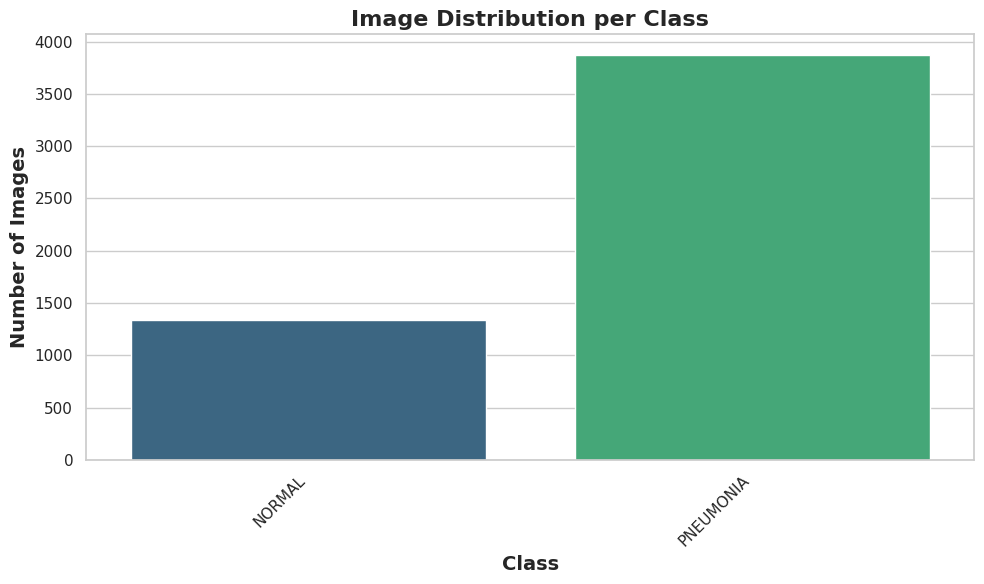

Processing Validation dataset...
Image counts for Validation: {'PNEUMONIA': 8, 'NORMAL': 8}


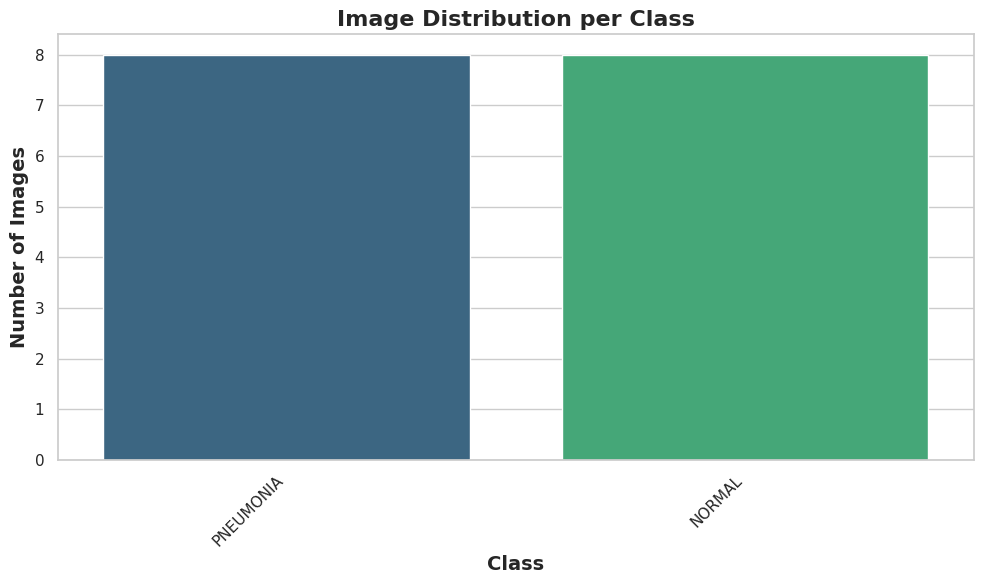

Processing Test dataset...
Image counts for Test: {'PNEUMONIA': 390, 'NORMAL': 234}


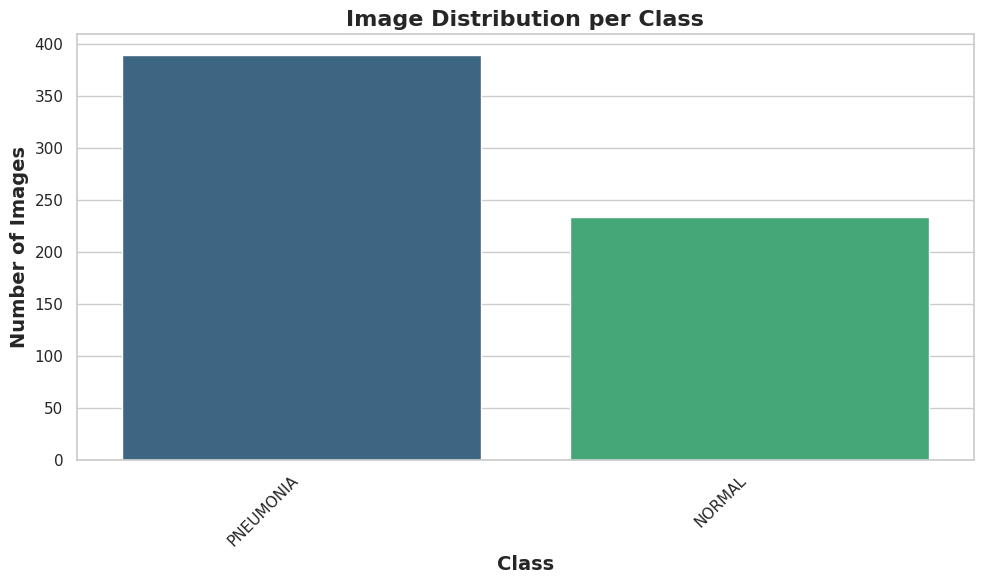

In [11]:
def count_images(dir_path):
    """
    Counts the number of images in each subdirectory for the given directory path.
    """
    counts = {}
    for class_name in os.listdir(dir_path):
        class_dir = os.path.join(dir_path, class_name)
        if os.path.isdir(class_dir):
            counts[class_name] = len(os.listdir(class_dir))
    return counts

def visualize_counts(counts_dict):
    """
    Visualizes the image counts using a bar chart.
    """
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    classes = list(counts_dict.keys())
    counts = list(counts_dict.values())
    sns.barplot(x=classes, y=counts, palette="viridis")
    plt.xlabel('Class', fontsize=14, fontweight='bold')
    plt.ylabel('Number of Images', fontsize=14, fontweight='bold')
    plt.title('Image Distribution per Class', fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

DATASET_DIRS = {
    "Train": train_dir,
    "Validation": val_dir,
    "Test": test_dir
}

for dataset_name, dir_path in DATASET_DIRS.items():
    print(f"Processing {dataset_name} dataset...")
    counts = count_images(dir_path)
    print(f"Image counts for {dataset_name}: {counts}")
    visualize_counts(counts)

In [12]:
def display_sample_images(dir, class_, num_samples=3):
    class_dir = os.path.join(dir, class_)
    sample_images = random.sample(os.listdir(class_dir), num_samples)

    fig, axes = plt.subplots(1, num_samples, figsize=(20, 20))
    for ax, image in zip(axes, sample_images):
        img_path = os.path.join(class_dir, image)
        img = mpimg.imread(img_path)
        ax.imshow(img, cmap='gray')
        ax.axis('off')
    plt.show()

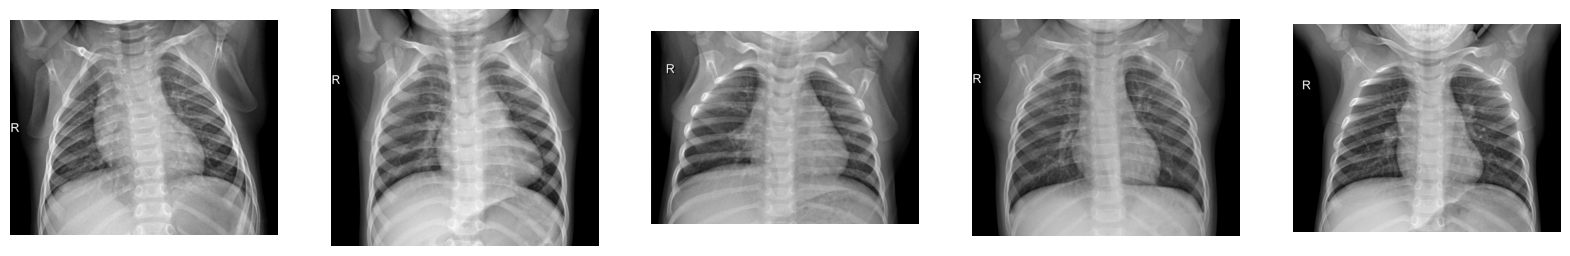

In [13]:
display_sample_images(train_dir, 'NORMAL', 5)

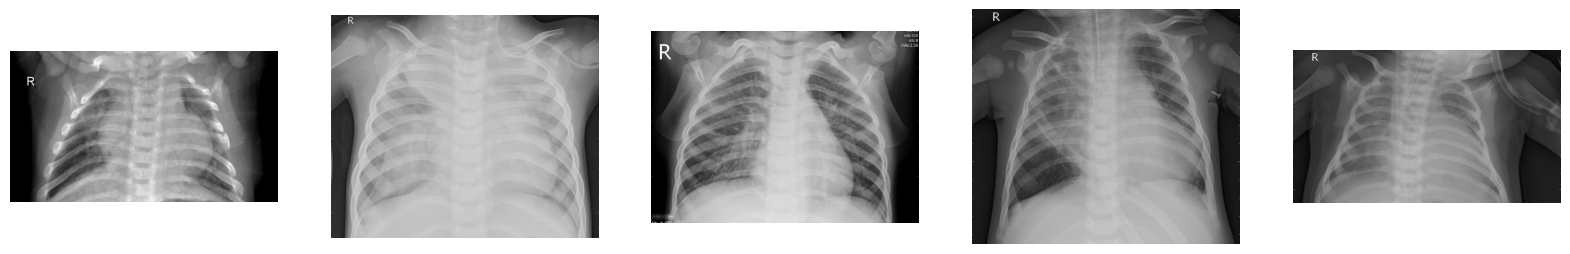

In [14]:
display_sample_images(train_dir, 'PNEUMONIA', 5)

---
## Data Preprocessing & Augmentation


In [15]:
# Define constants
ROTATION_RANGE = 20
WIDTH_SHIFT_RANGE = 0.1
HEIGHT_SHIFT_RANGE = 0.1
HORIZONTAL_FLIP = True
FILL_MODE = 'nearest'
TARGET_SIZE = (300, 300)
RESCALE = 1. / 255.
BATCH_SIZE = 32

def create_augmented_data_generator(train_dir):
    """
    Create a data generator for training images with augmentation.

    Args:
        train_dir (str): Path to the directory containing training images.

    Returns:
        DirectoryIterator: Data generator for training images with augmentation.
    """
    train_datagen = ImageDataGenerator(
        rotation_range=ROTATION_RANGE,
        width_shift_range=WIDTH_SHIFT_RANGE,
        height_shift_range=HEIGHT_SHIFT_RANGE,
        horizontal_flip=HORIZONTAL_FLIP,
        fill_mode=FILL_MODE,
        rescale=RESCALE
    )

    train_data_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary'
    )

    return train_data_generator

def create_val_data_generator(val_dir):
    """
    Create a data generator for validation images without augmentation.

    Args:
        val_dir (str): Path to the directory containing validation images.

    Returns:
        DirectoryIterator: Data generator for validation images without augmentation.
    """
    val_datagen = ImageDataGenerator(rescale=RESCALE)

    val_data_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary'
    )

    return val_data_generator

def create_test_data_generator(test_dir):
    """
    Create a data generator for test images without augmentation.

    Args:
        test_dir (str): Path to the directory containing test images.

    Returns:
        DirectoryIterator: Data generator for test images without augmentation.
    """
    test_datagen = ImageDataGenerator(rescale=RESCALE)

    test_data_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary'
    )

    return test_data_generator

In [16]:
# Call the function to create augmented data generator for training set
train_data_generator = create_augmented_data_generator(train_dir)

# Call the function to create data generator for validation set
val_data_generator = create_val_data_generator(val_dir)

# Call the function to create data generator for test set
test_data_generator = create_test_data_generator(test_dir)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


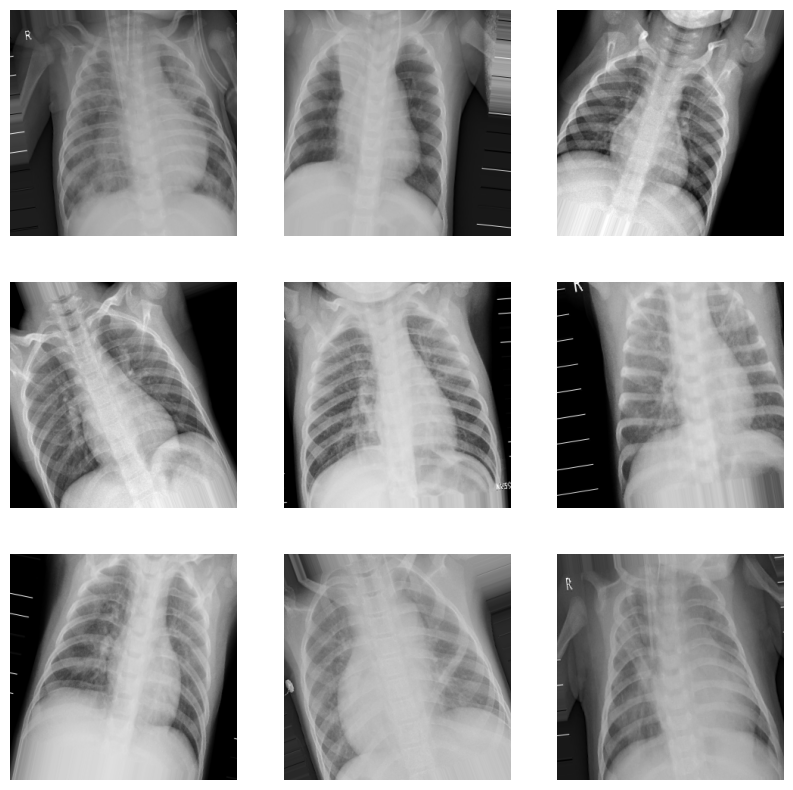

In [17]:
for i, (images, labels) in enumerate(train_data_generator):
    if i == 1:
        break  # We only want to see the first batch
    plt.figure(figsize=(10, 10))
    for j in range(9):  # Display the first 9 images of the batch
        ax = plt.subplot(3, 3, j + 1)
        plt.imshow(images[j])
        plt.axis("off")

---
## CNN Architecture Development

In [ ]:
#class_weight_dict =

In [25]:
model = tf.keras.models.Sequential([
    # Initialise the input layer with the input shape
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', strides=(2, 2), input_shape=(300, 300,3), name="First_Convolution"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(rate=0.3, name='Dropout_1'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Middle convolutional layers to extract features
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', strides=(2, 2), name="Second_Convolution"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(rate=0.3, name='Dropout_2'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Last convolutional layers to extract higher level features
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', strides=(2, 2), name="Third_Convolution"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(rate=0.4, name='Dropout_3'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

    # Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [26]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001, mode='min', verbose=1)

In [27]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 First_Convolution (Conv2D)  (None, 150, 150, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 150, 150, 32)      128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 150, 150, 32)      0         
                                                                 
 Dropout_1 (Dropout)         (None, 150, 150, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 Second_Convolution (Conv2D  (None, 38, 38, 64)        1

#### **Model Observations**

In [30]:
history = model.fit(train_data_generator,
                    epochs=3,
                    validation_data=val_data_generator,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])

Epoch 1/3
163/163 [==============================] - 449s 3s/step - loss: 0.4540 - accuracy: 0.8781 - val_loss: 2.7462 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/3
163/163 [==============================] - 430s 3s/step - loss: 0.1671 - accuracy: 0.9362 - val_loss: 3.5721 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/3
163/163 [==============================] - 416s 3s/step - loss: 0.1513 - accuracy: 0.9433 - val_loss: 3.0652 - val_accuracy: 0.5000 - lr: 0.0010


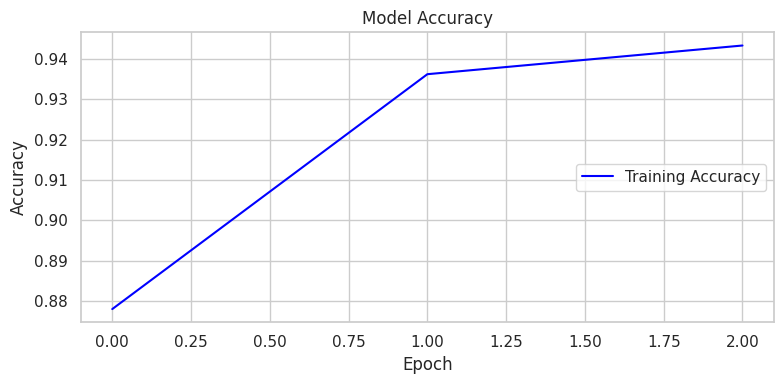

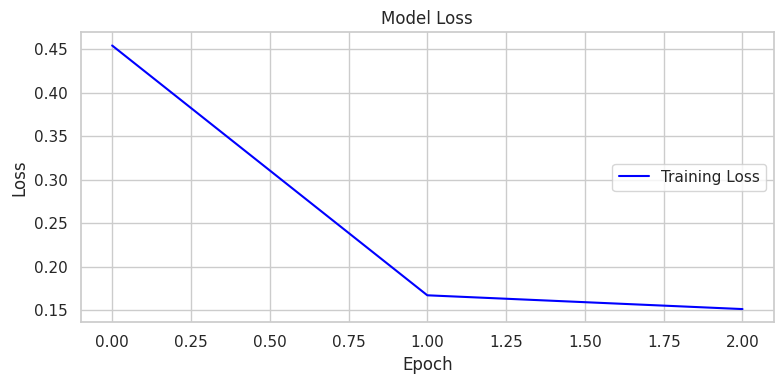

In [32]:
def plot_metrics(history, metric='accuracy'):
    plt.figure(figsize=(8, 4))
    plt.plot(history.history[metric], label='Training ' + metric.capitalize(), color='blue', linestyle='-')
    plt.title('Model ' + metric.capitalize())
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend(loc='center right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_metrics(history, metric='accuracy')
plot_metrics(history, metric='loss')

---
## Hyperparametre Tuning

After addressing the immediate model improvements, a chapter on hyperparameter tuning can focus on systematic approaches to finding the best model configuration. Topics to cover could include:

Introduction to Hyperparameter Tuning: Understanding what hyperparameters are and why tuning them is crucial for model performance.
Manual vs. Automated Tuning: The pros and cons of manual tuning versus using automated tools like Grid Search, Random Search, Bayesian Optimization, and others.
Using Keras Tuner: An introduction to Keras Tuner, a library for automated hyperparameter tuning with TensorFlow, including practical examples.
Practical Tips for Tuning: Best practices for conducting hyperparameter tuning, such as how to select which hyperparameters to tune, setting up your tuning domain, and interpreting tuning results.
Advanced Techniques: An overview of more sophisticated tuning strategies, such as multi-fidelity optimization and meta-learning.

In [36]:
def build_model(hp):
    model = tf.keras.Sequential([
        # First convolutional layer
        tf.keras.layers.Conv2D(
            hp.Int('conv_1_filter', min_value=32, max_value=128, step=32),
            (hp.Choice('conv_1_kernel', values=[3, 5])),
            padding='same', strides=(2, 2), input_shape=(300, 300, 3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(rate=hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)),
        tf.keras.layers.MaxPooling2D(2, 2),

        # Second convolutional layer
        tf.keras.layers.Conv2D(
            hp.Int('conv_2_filter', min_value=64, max_value=256, step=64),
            (hp.Choice('conv_2_kernel', values=[3, 5])),
            padding='same', strides=(2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(rate=hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)),
        tf.keras.layers.MaxPooling2D(2, 2),

        # Third convolutional layer
        tf.keras.layers.Conv2D(
            hp.Int('conv_3_filter', min_value=128, max_value=512, step=128),
            (hp.Choice('conv_3_kernel', values=[3, 5])),
            padding='same', strides=(2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(rate=hp.Float('dropout_3', min_value=0.2, max_value=0.5, step=0.1)),
        tf.keras.layers.MaxPooling2D(2, 2),

        # Flatten and Dense layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(
            hp.Int('dense_units', min_value=256, max_value=1024, step=256),
            activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(
            hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        metrics=['accuracy']
    )

    return model

# Instantiate the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='keras_tuner_demo'
)

# Display search space summary
tuner.search_space_summary()

# Calculate steps per epoch for training and validation steps
steps_per_epoch = train_data_generator.samples // train_data_generator.batch_size
validation_steps = val_data_generator.samples // val_data_generator.batch_size

# Start hyperparameter search with the data generators
tuner.search(
    train_data_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=val_data_generator,
    validation_steps=validation_steps,
    callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=3)]  # Optional: add early stopping for efficiency
)

# After search completes, get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('dense_units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)


Trial 2 Complete [00h 19m 12s]

Best val_accuracy So Far: None
Total elapsed time: 00h 26m 43s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
96                |32                |conv_1_filter
3                 |3                 |conv_1_kernel
0.4               |0.3               |dropout_1
64                |64                |conv_2_filter
5                 |5                 |conv_2_kernel
0.2               |0.4               |dropout_2
512               |256               |conv_3_filter
5                 |3                 |conv_3_kernel
0.4               |0.3               |dropout_3
768               |512               |dense_units
0.0071211         |0.00091437        |learning_rate

Epoch 1/10
163/163 [==============================] - ETA: 0s - loss: 5.1217 - accuracy: 0.8257

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 273, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 238, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, i

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 273, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 238, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/data_adapter.py", line 1275, in __init__
    raise ValueError(
ValueError: Unexpected value for `steps_per_epoch`. Received value is 0. Please check the docstring for `model.fit()` for supported values.


In [ ]:
history = model.fit(train_data_generator,
                    epochs=30,
                    validation_data=val_data_generator,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])

Exception ignored in: <function _xla_gc_callback at 0x7b86491a92d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


Epoch 1/30
163/163 [==============================] - 418s 3s/step - loss: 0.1427 - accuracy: 0.9448 - val_loss: 2.3008 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/30
 46/163 [=======>......................] - ETA: 4:59 - loss: 0.1411 - accuracy: 0.9450

---
## Model Evaluation

- Confusion Matrix
Predicted vs Actual


In [ ]:
plot_metrics(history, metric='accuracy')
plot_metrics(history, metric='loss')

In [ ]:
# Load the best model saved by ModelCheckpoint callback
model = tf.keras.models.load_model('best_model.h5')

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_data_generator)

print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)

---
## Summary & Retrospective

---
## References:

Varshni, D., Thakral, K., Agarwal, L., Nijhawan, R. and Mittal, A. (2019). Pneumonia Detection Using CNN based Feature Extraction. [online] IEEE Xplore. doi:https://doi.org/10.1109/ICECCT.2019.8869364.